In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import scipy
import os

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

# Define Simulation functions

## Simulate Spatial Noise

Takes a layer, rotates by angle. Next, we map all coordinates to closest integer coordinates.

This removes some points as two points who share the same closest integer pair will map to same coordinate.

In [2]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        # plt.show()

    return new_spots,mapping

def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 40
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

## Simulate Gene Expression

In [3]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X)
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

## Define Simulation Accuracy Metric

Since we know the rotation for the simulated layer, we know the exact mapping and thus can calculate % of spots correctly aligned.

In [4]:
def getSimulationAccuracy(adata_layer, adata_layer_sim, mapping, alpha):
    l = adata_layer.copy()
    siml = adata_layer_sim.copy()
    G = paste.pairwise_align(l, siml, alpha= alpha)
    s = 0
    for i in range(len(mapping)):
        s += G[mapping[i]][i]
    return s

## PASTE Simulation

Given an initial layer, we simulate a new layer by perturbing spatial and gene expression information. Then, we run pairwise alignment and report the % of spots correctly mapped since we know the true mapping.

In [5]:
def simulate_once(adata_layer, pseudocounts): 
    adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer, math.pi/3)
    
    # because we are varying pseudocounts, want to resimulate gene expression
    for p in pseudocounts:
        if p == 0:
            # add the factor = 0 case
            max_accuracy = adata_layer_sim_spatial.shape[0]/adata_layer.shape[0]
            baseline = [max_accuracy]
            mixed_0_01 = [max_accuracy]
            mixed_0_1 = [max_accuracy]
            mixed_0_2 = [max_accuracy]
            mixed_0_5 = [max_accuracy]
            mixed_0_9 = [max_accuracy]


            s = getSimulationAccuracy(adata_layer, adata_layer_sim_spatial, mappings, 1)
            spatial = [s]
        else:
            adata_layer_sim_both = adata_layer_sim_spatial.copy()
            adata_layer_sim_both = simulate_gene_exp(adata_layer_sim_both, pc = p)
            b = getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0)

            baseline.append(b)
            mixed_0_01.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.01))
            mixed_0_1.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.1))
            mixed_0_2.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.2))
            mixed_0_5.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.5))
            mixed_0_9.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.9))
            spatial.append(s)
    return baseline, mixed_0_01, mixed_0_1, mixed_0_2, mixed_0_5, mixed_0_9, spatial


## Scanorama Simulation

Given an initial layer, we simulate a new layer by perturbing spatial and gene expression information. Next, we run Scanorama on the simulated layer. Finally, we run basic optimal transport between gene expression matrices of the true layer and Scanorama integrated layer and calculate % of spots correctly mapped.

In [6]:
import ot
import scanorama

def EDM(A, B):
    p1 = np.sum(A**2, axis = 1)[:, np.newaxis]
    p2 = np.sum(B**2, axis = 1)
    p3 = -2 * np.dot(A, B.T)
    return np.sqrt(p1+p2+p3)

def scanorama_pairwise_sim(adata_layer, p):
    adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer, math.pi/3)
    adata_layer_sim_both = simulate_gene_exp(adata_layer_sim_spatial, pc = p)
    layers = [adata_layer.copy(), adata_layer_sim_both]

    datasets = []
    genes_list = []
    for l in layers:
        datasets.append(l.X)
        genes_list.append(list(l.var.index))

    integrated, corrected, genes = scanorama.correct(datasets, genes_list, return_dimred=True)
    D = EDM(integrated[0],integrated[1])
    a = np.ones((integrated[0].shape[0],)) / integrated[0].shape[0]
    b = np.ones((integrated[1].shape[0],)) / integrated[1].shape[0]  # uniform distribution on samples
    G = ot.emd(a, b, D)
    s = 0
    for i in range(len(mappings)):
        s += G[mappings[i]][i]
    return s

# Run Experiment

## Read in Data

In [7]:
def load_breast_layer(path):
    X = pd.read_csv(path, delimiter = '\t', index_col= 0)
    coor = []
    for c in X.index:
        coor.append([float(x) for x in c.split('x')])
    adata = anndata.AnnData(X = X)
    adata.obsm['spatial'] = np.array(coor)
    return adata

In [8]:
layer1_path = "../breast_cancer_data/Layer1_BC_count_matrix-1.tsv"
layer2_path = "../breast_cancer_data/Layer2_BC_count_matrix-1.tsv"
layer3_path = "../breast_cancer_data/Layer3_BC_count_matrix-1.tsv"
layer4_path = "../breast_cancer_data/Layer4_BC_count_matrix-1.tsv"

adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

## Results

In [9]:
slices = {
    "SliceA" : adata_layer_1,
    "SliceB" : adata_layer_2,
    "SliceC" : adata_layer_3,
    "SliceD" : adata_layer_4
}

Make folders to store results if necessary

In [10]:
path_to_output_dir = '../data/Stahl-BC/cached-results/pairwise-sim/'

if not os.path.exists(path_to_output_dir):
    os.makedirs(path_to_output_dir)
for slice_name, adata in slices.items():
    sub_dir = path_to_output_dir + slice_name + '/'
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir)

Define constants between PASTE and Scanorama Experiment

In [11]:
# Number of runs per experiment
N_RUNS = 10
pseudocounts = list(range(6))

Run PASTE pairwise simulation

Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 14880 common genes.
Filtered all slices for common genes. There are 

Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 14789 common genes.
Filtered all slices for common genes. There are 

Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 14929 common genes.
Filtered all slices for common genes. There are 

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.


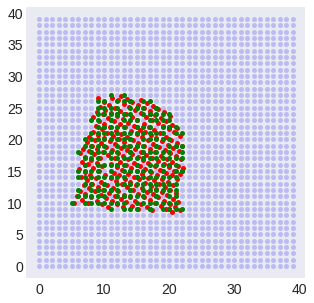

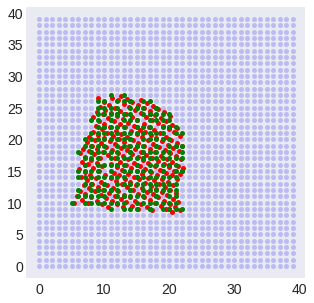

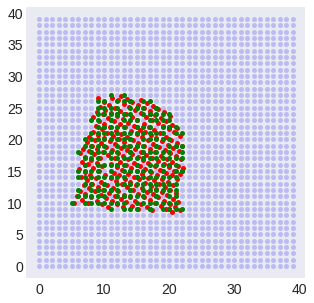

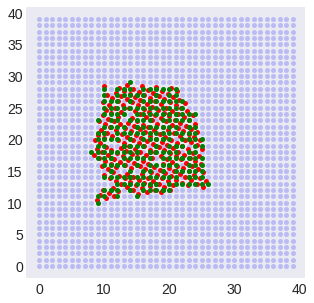

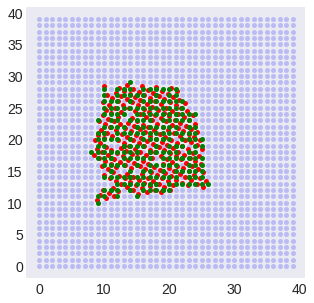

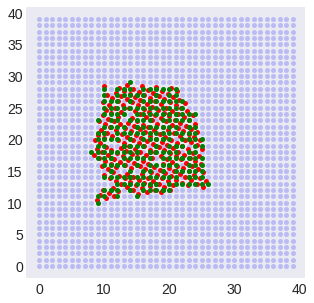

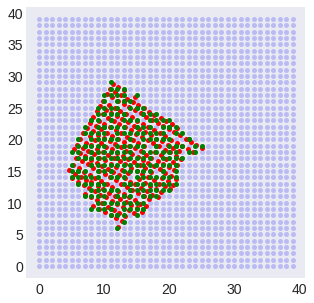

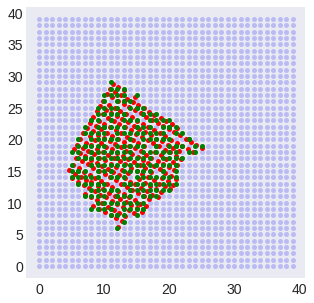

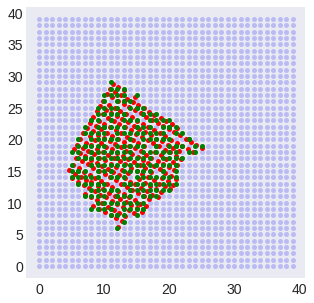

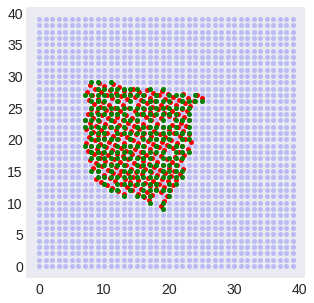

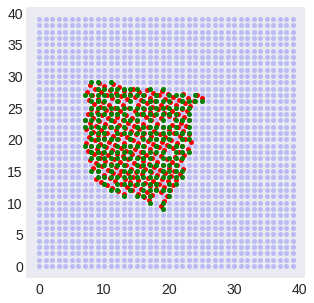

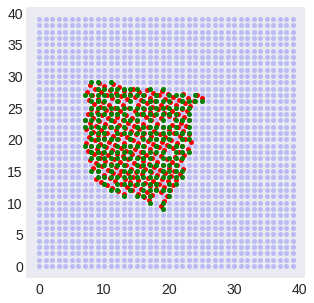

In [12]:
for slice_name, adata in slices.items():
    baseline_all = []
    mixed_0_01_all = []
    mixed_0_1_all = []
    mixed_0_2_all = []
    mixed_0_5_all = []
    mixed_0_9_all = []
    spatial_all = []
    for i in range(N_RUNS):
        b, m_0_01,  m_0_1,  m_0_2,  m_0_5, m_0_9, s  = simulate_once(adata, pseudocounts)
        baseline_all.append(b)
        mixed_0_01_all.append(m_0_01)
        mixed_0_1_all.append(m_0_1)
        mixed_0_2_all.append(m_0_2)
        mixed_0_5_all.append(m_0_5)
        mixed_0_9_all.append(m_0_9)
        spatial_all.append(s)
    
    pd.DataFrame(baseline_all, columns = pseudocounts).to_csv(path_to_output_dir + slice_name + '/baseline.csv')
    pd.DataFrame(mixed_0_01_all, columns = pseudocounts).to_csv(path_to_output_dir + slice_name +'/mixed_0.01.csv')
    pd.DataFrame(mixed_0_1_all, columns = pseudocounts).to_csv(path_to_output_dir + slice_name + '/mixed_0.1.csv')
    pd.DataFrame(mixed_0_2_all, columns = pseudocounts).to_csv(path_to_output_dir + slice_name + '/mixed_0.2.csv')
    pd.DataFrame(mixed_0_5_all, columns = pseudocounts).to_csv(path_to_output_dir + slice_name +'/mixed_0.5.csv')
    pd.DataFrame(mixed_0_9_all, columns = pseudocounts).to_csv(path_to_output_dir + slice_name +'/mixed_0.9.csv')
    pd.DataFrame(spatial_all, columns = pseudocounts).to_csv(path_to_output_dir + slice_name +'/spatial.csv')

Run Scanorama Simulation

Iteration: 0
Found 14880 genes among all datasets
[[0.         0.98425197]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 1
Found 14880 genes among all datasets
[[0.         0.99606299]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 14880 genes among all datasets
[[0.         0.68

/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 1
Found 14880 genes among all datasets


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.         0.99606299]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 2
Found 14880 genes among all datasets


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.         0.99606299]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 0
Found 14880 genes among all datasets


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.         0.99606299]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 1
Found 14880 genes among all datasets


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.         0.99606299]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 2
Found 14880 genes among all datasets


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.         0.99606299]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 0
Found 14880 genes among all datasets


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.         0.99606299]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 1
Found 14880 genes among all datasets


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.         0.99606299]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 2
Found 14880 genes among all datasets


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[0.         0.99606299]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.92272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.68636364]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.52272727]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.58181818]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/max/Programs/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Found 14880 genes among all datasets
[[0.         0.49545455]
 [0.         0.        ]]
Processing datasets (0, 1)


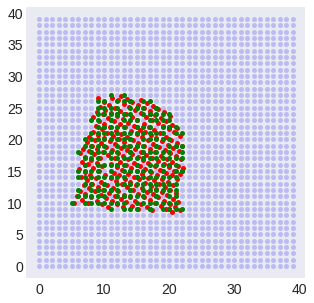

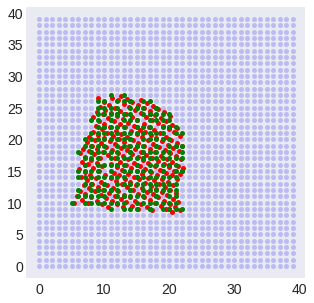

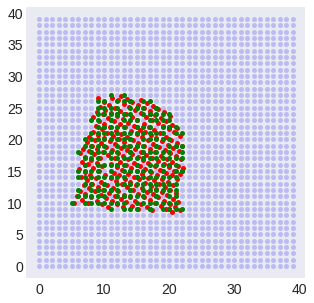

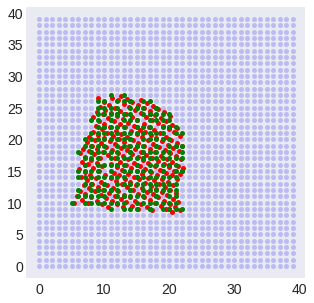

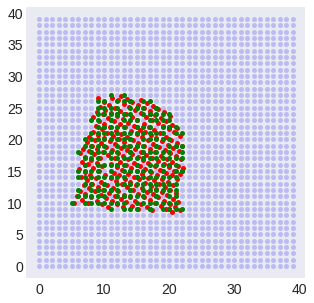

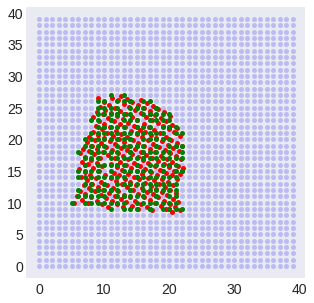

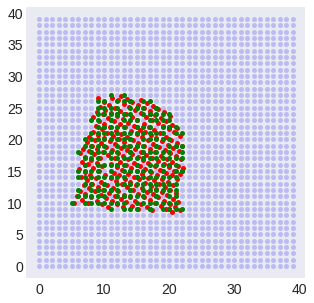

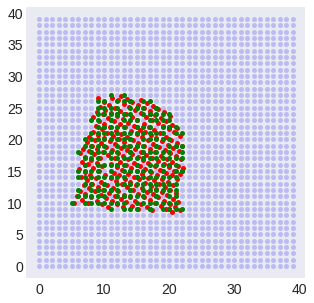

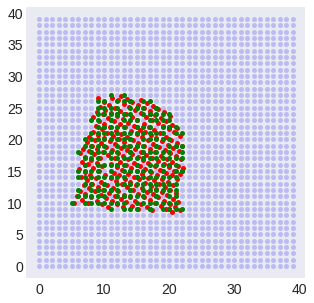

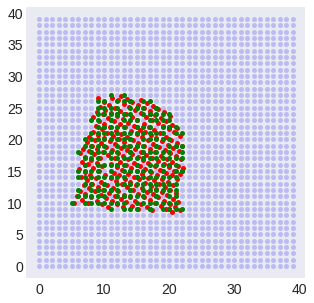

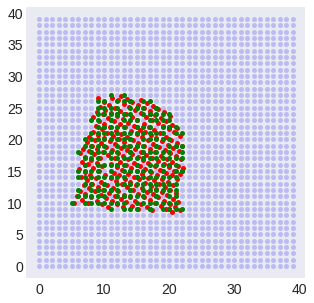

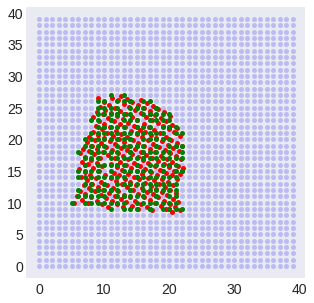

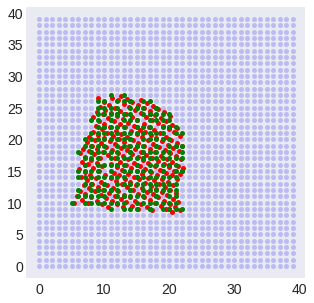

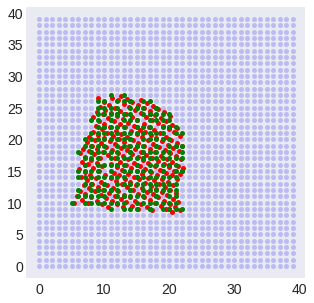

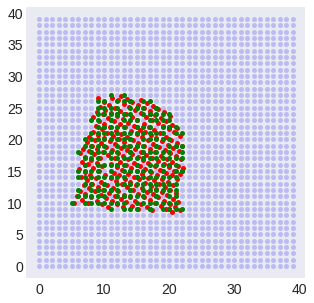

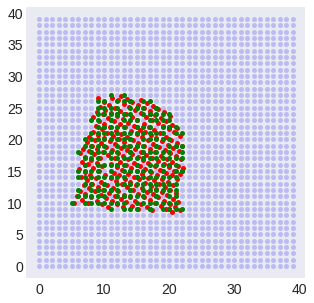

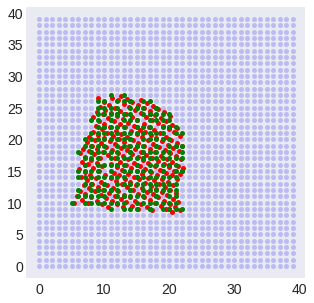

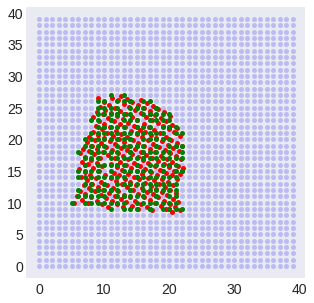

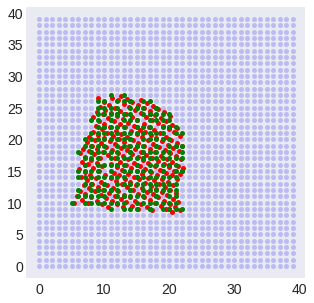

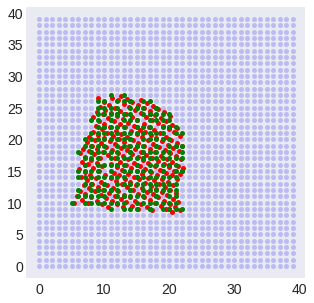

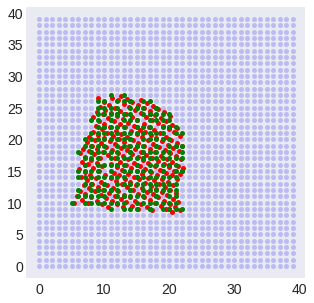

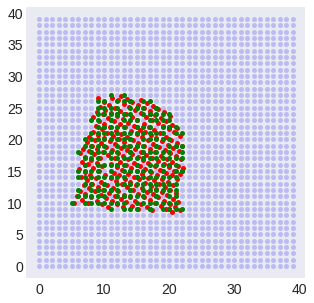

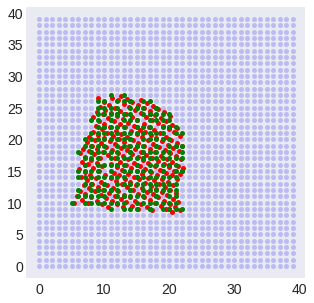

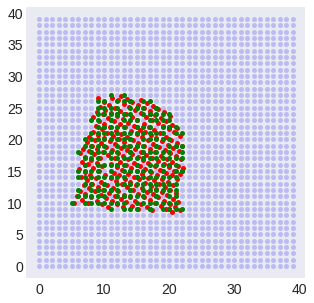

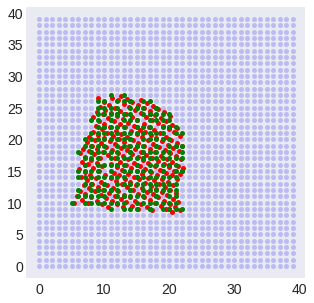

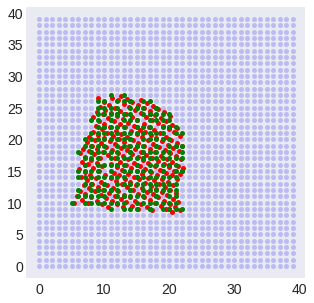

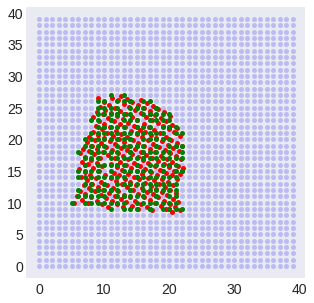

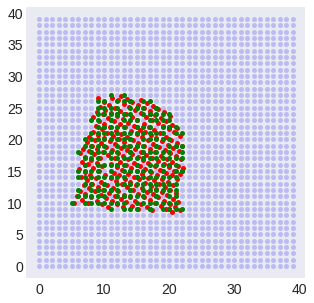

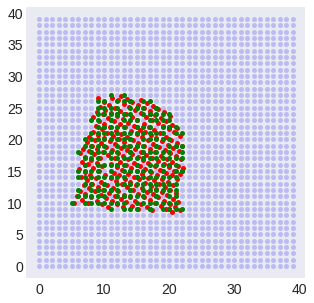

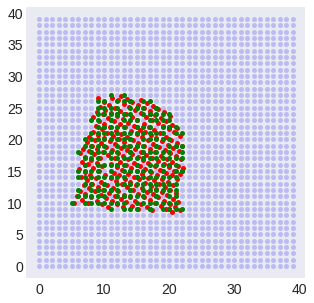

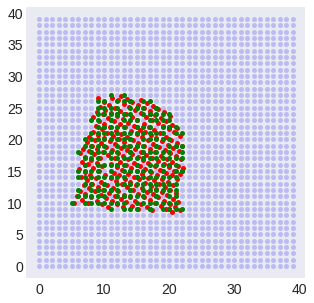

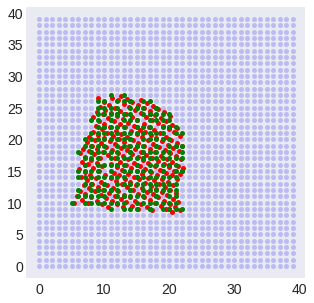

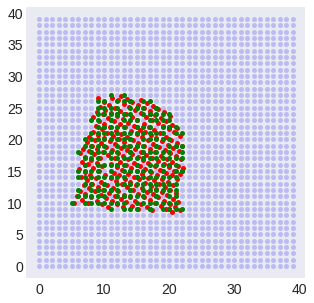

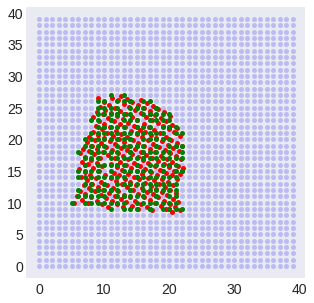

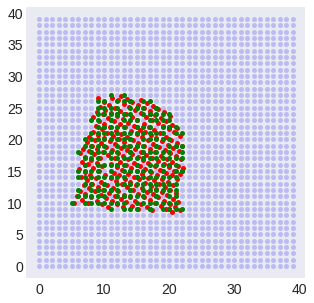

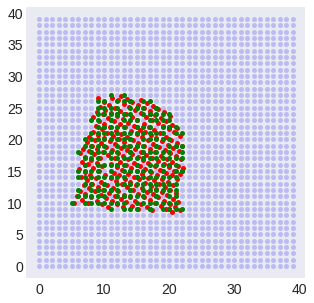

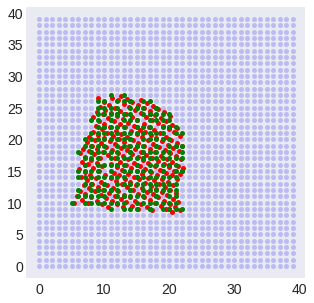

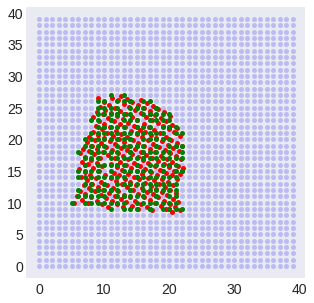

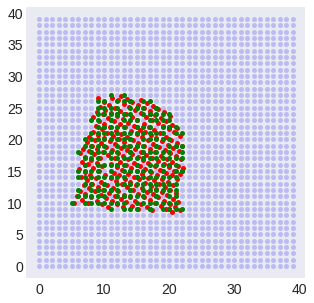

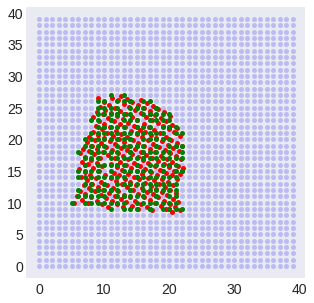

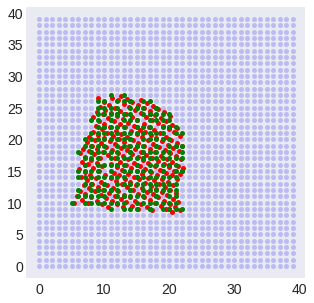

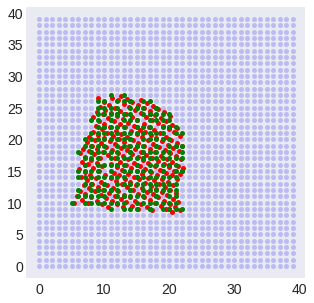

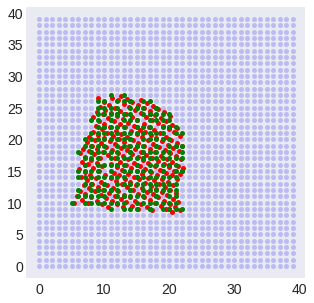

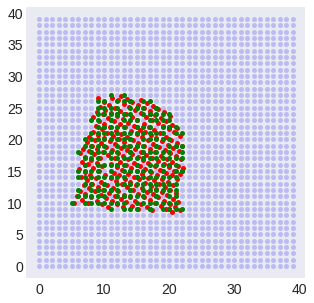

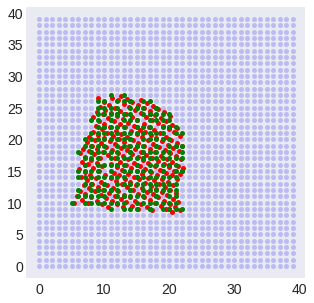

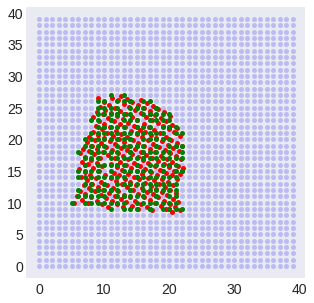

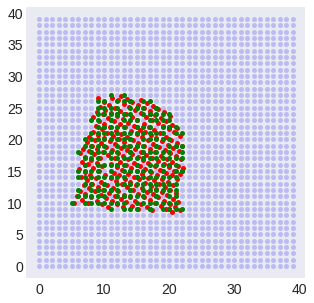

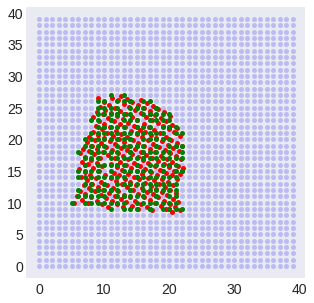

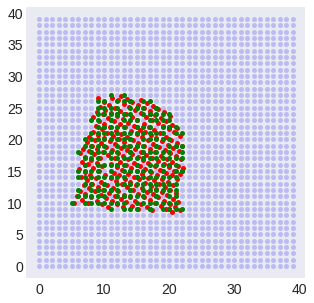

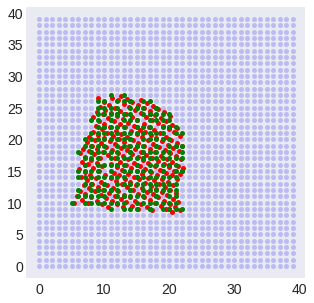

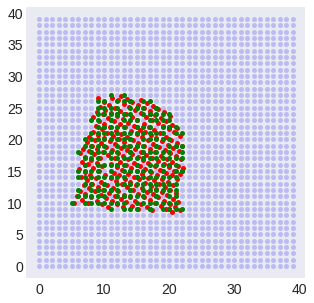

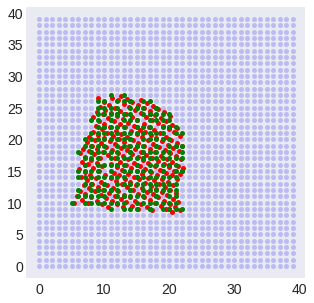

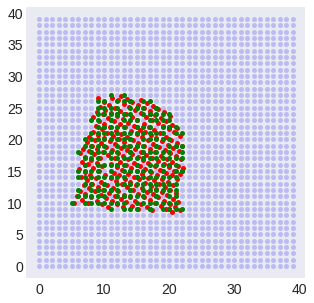

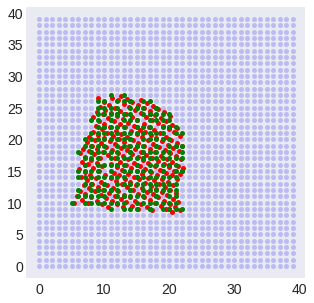

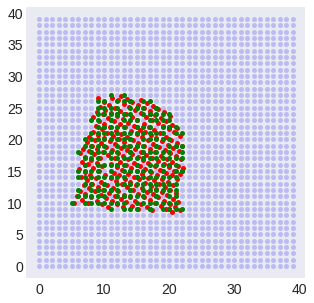

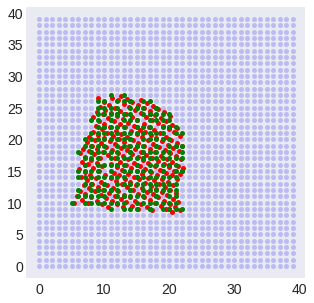

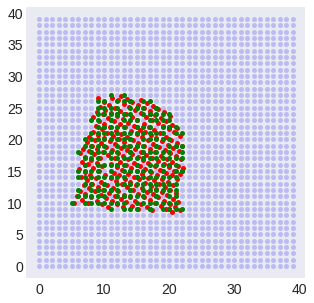

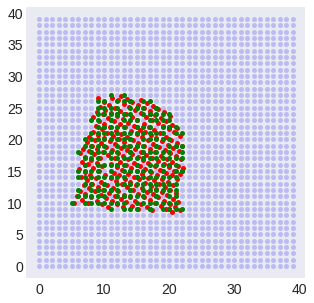

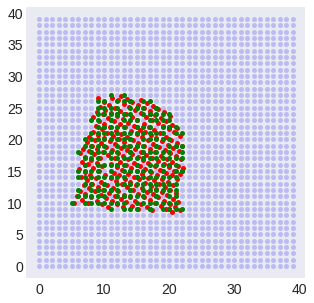

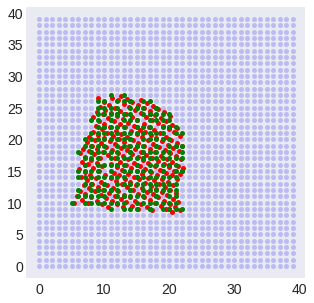

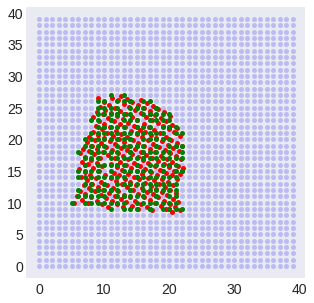

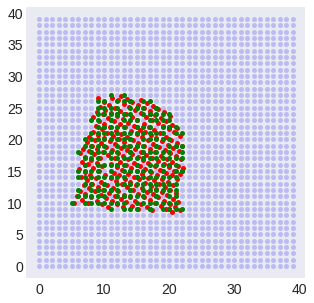

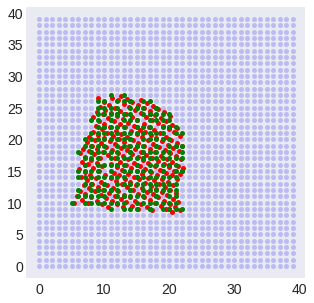

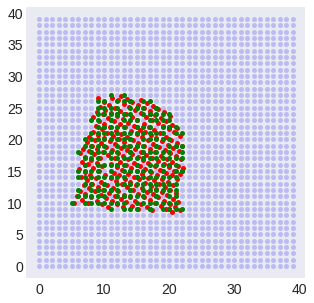

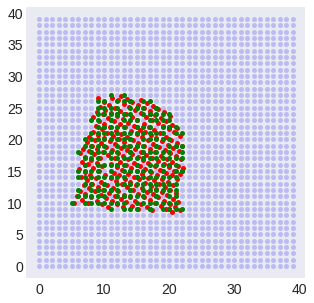

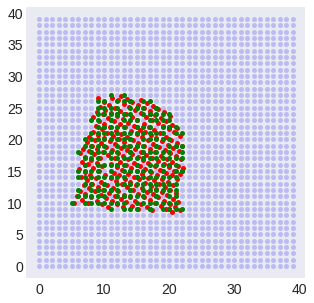

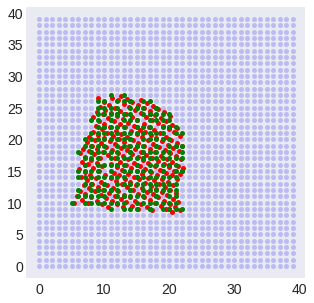

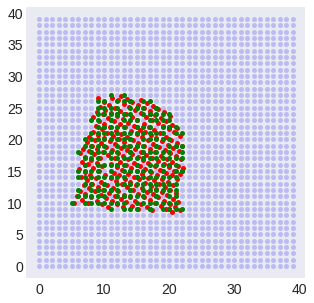

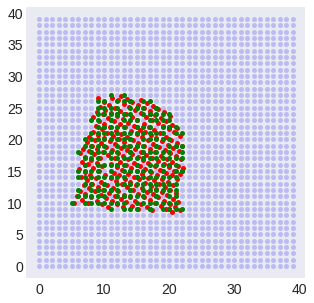

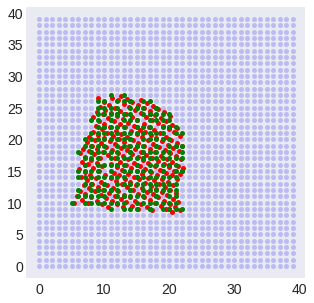

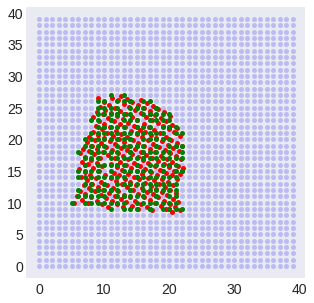

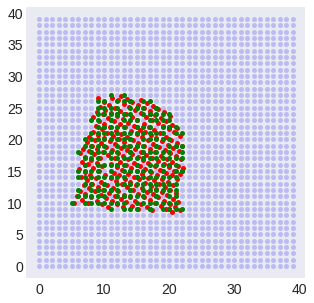

In [13]:
for slice_name, adata in slices.items():
    runs = []
    for i in range(N_RUNS):
        print("Iteration: " + str(i))
        results = []
        for p in pseudocounts:
            results.append(scanorama_pairwise_sim(adata_layer_1, p))
        runs.append(results)
        pd.DataFrame(runs).to_csv(path_to_output_dir + slice_name + '/scanorama.csv')

# Plot Results

In [4]:
path_to_output_dir = "../data/Stahl-BC/cached-results/pairwise-sim/"

alpha_to_filename = {
    0 : 'baseline.csv',
    0.01 : 'mixed_0.01.csv',
    0.1 : 'mixed_0.1.csv',
    0.2 : 'mixed_0.2.csv',
    0.5 : 'mixed_0.5.csv',
    0.9 : 'mixed_0.9.csv',
    1 : 'spatial.csv',    
    'scanorama' : 'scanorama.csv'
}

In [5]:
mean = {}
sd = {}
for alpha in alpha_to_filename.keys():
    mean[alpha] = []
    sd[alpha] = []   


for s in ['SliceA', 'SliceB', 'SliceC', 'SliceD']:
    for alpha in alpha_to_filename:
        path = path_to_output_dir + s + '/' + alpha_to_filename[alpha]
        mean[alpha].append(pd.read_csv(path, index_col= 0).mean())
        sd[alpha].append(pd.read_csv(path, index_col= 0).std())
        
# Since all pseudocounts should be the same, we just take the last one.
pseudocounts = [float(pc) for pc in mean[alpha][0].index]

Slice B

C:\Users\maxru\anaconda3\envs\scri\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\maxru\anaconda3\envs\scri\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\maxru\anaconda3\envs\scri\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

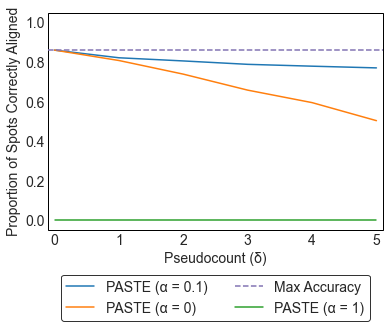

In [6]:
x = pseudocounts
# Slice B corresponds to the second slice in the results
i = 2
max_accuracy = mean[0.1][i][0]

ax = sns.lineplot(x, mean[0.1][i], label = "PASTE (α = 0.1)")
ax = sns.lineplot(x, mean[0][i], label = "PASTE (α = 0)")
ax = sns.lineplot(x, mean[1][i], label = "PASTE (α = 1)")
ax.axhline(max_accuracy, linestyle='--', label = 'Max Accuracy', c = '#8172b2')


ax.set(xlim=(-0.1,5.1), ylim=(-0.05,1.05))
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
ax.set_xlabel('Pseudocount (δ)', fontsize = 14)
ax.set_ylabel('Proportion of Spots Correctly Aligned', fontsize = 14)
h, l = ax.get_legend_handles_labels()
handles = [h[0],h[1],h[3],h[2]] 
labels = [l[0],l[1],l[3],l[2]] 
ax.legend(handles, labels, loc= 'lower center', bbox_to_anchor=(0.5, -0.45), ncol=2, frameon=True, edgecolor='black', facecolor='white', fontsize = 14)
ticks = plt.xticks(np.arange(min(x), max(x)+1, 1.0))

All Slices

['Max Accuracy', 'α = 0.1 (Mixed)', 'α = 0 (Gene Exp Only)', 'α = 1 (Spatial Only)', 'Scanorama + OT', 'α = 0.01 (Mixed)', 'α = 0.2 (Mixed)', 'α = 0.5 (Mixed)', 'α = 0.9 (Mixed)']


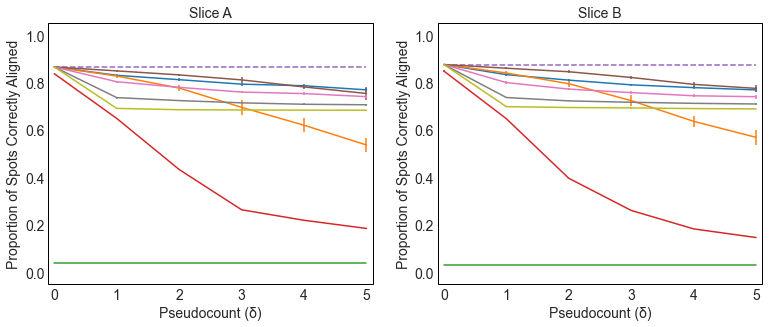

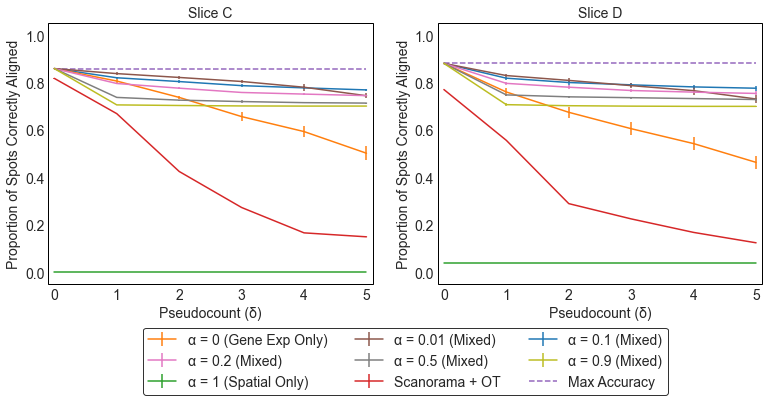

In [7]:
f, ax = plt.subplots(1,2, figsize=(12.8, 4.8))
f1, ax1 = plt.subplots(1,2, figsize=(12.8, 4.8))
# Setting the values for all axes.
plt.setp(ax, xlim=(-0.1,5.1), ylim=(-0.05,1.05))

title = dict(zip(range(4), ['Slice A', 'Slice B', 'Slice C', 'Slice D']))
x = pseudocounts

for a, i in zip([ax[0], ax[1], ax1[0], ax1[1]], range(4)):
    a.errorbar(x, mean[0.1][i], yerr = sd[0.1][i], label = "α = 0.1 (Mixed)")
    a.errorbar(x, mean[0][i], yerr = sd[0][i], label= "α = 0 (Gene Exp Only)")
    a.errorbar(x, mean[1][i], yerr = sd[1][i], label = "α = 1 (Spatial Only)")
    a.errorbar(x, mean['scanorama'][i][0:6], yerr = sd['scanorama'][i][0:6], label = "Scanorama + OT")

    m1 = 6*[mean[0.1][i][0]]
    a.plot(x, m1, '--', label = "Max Accuracy")

    a.errorbar(x, mean[0.01][i], yerr = sd[0.01][i], label = "α = 0.01 (Mixed)")
    a.errorbar(x, mean[0.2][i], yerr = sd[0.2][i], label = "α = 0.2 (Mixed)")
    a.errorbar(x, mean[0.5][i], yerr = sd[0.5][i], label = "α = 0.5 (Mixed)")
    a.errorbar(x, mean[0.9][i], yerr = sd[0.9][i], label = "α = 0.9 (Mixed)")
    a.set_title(title[i], fontsize = 14)

for i in range(2):
    ax[i].set(xlim=(-0.1,5.1), ylim=(-0.05,1.05))
    ax[i].set_facecolor('white')
    ax[i].patch.set_edgecolor('black')
    ax[i].patch.set_linewidth('1')  
    ax[i].set_xlabel('Pseudocount (δ)', fontsize = 14)
    ax[i].set_ylabel('Proportion of Spots Correctly Aligned', fontsize = 14)
    ax[i].set_xticks(np.arange(min(x), max(x)+1, 1.0))
    
    ax1[i].set(xlim=(-0.1,5.1), ylim=(-0.05,1.05))
    ax1[i].set_facecolor('white')
    ax1[i].patch.set_edgecolor('black')
    ax1[i].patch.set_linewidth('1')  
    ax1[i].set_xlabel('Pseudocount (δ)', fontsize = 14)
    ax1[i].set_ylabel('Proportion of Spots Correctly Aligned', fontsize = 14)
    ax1[i].set_xticks(np.arange(min(x), max(x)+1, 1.0))

h, l = ax1[1].get_legend_handles_labels()
handles = [h[2], h[6], h[3], h[5], h[7], h[4], h[1], h[8], h[0]] 
labels = [l[2], l[6], l[3], l[5], l[7], l[4], l[1], l[8], l[0]] 
print(l)
ax1[1].legend(handles, labels, loc = 'lower center', bbox_to_anchor=(-0.1, -0.45), frameon=True, edgecolor='black', facecolor='white', ncol=3, fontsize=14)
plt.show()
# f.savefig('breast_sim_A1_v2.pdf', dpi = 300, bbox_inches = "tight")
# f1.savefig('breast_sim_B1_v2.pdf', dpi = 300, bbox_inches = "tight")